This analysys involves testing if a dataset with different liquids could generate a good XGBoost (Extrem Boost Gradient) model.
In this case we are NOT including the name of the liquid but we are including voltage, flow_rate, unidimensional voltage and unidimensional flow rate to the dataset.
In this time we are also treating the data differently. We now won't remove the infinite values of the dataframe, but replace them with the mean of non-zero values.

In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [112]:
df = pd.read_feather('../data/EW55_EW82_EW8515_EWG172_EWG343_EWP334_EWP361_EWP541_relabeled.feather')
print(df.shape)
df.head()

(102643, 12)


,index,name,mean,variance,deviation,median,rms,spray_mode,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage
0,0,setup/liquid/EW55,0.767964,13.973825,3.738158,0.756525,3.816228,Undefined,3000.40,1.0,6.378865e-11,2.440908
1,1,setup/liquid/EW55,0.939377,13.891714,3.727159,1.008700,3.843715,Undefined,3000.40,1.0,6.378865e-11,2.440908
2,2,setup/liquid/EW55,0.933078,14.675615,3.830877,1.008700,3.942873,Undefined,3000.40,1.0,6.378865e-11,2.440908
3,3,setup/liquid/EW55,1.222892,14.586572,3.819237,1.260875,4.010242,Undefined,3000.40,1.0,6.378865e-11,2.440908
4,4,setup/liquid/EW55,0.430110,14.113415,3.756783,0.504350,3.781324,Dripping,3200.44,1.0,6.378865e-11,2.777234


Data treatment - Replacing the "0" median values for the mean of non-zero values for Undefined and Dripping

In [113]:
non_zero_dripping_df = df.loc[(df['median'] != 0)]
print(non_zero_dripping_df.shape)
non_zero_dripping_df.head()

(99420, 12)


,index,name,mean,variance,deviation,median,rms,spray_mode,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage
0,0,setup/liquid/EW55,0.767964,13.973825,3.738158,0.756525,3.816228,Undefined,3000.40,1.0,6.378865e-11,2.440908
1,1,setup/liquid/EW55,0.939377,13.891714,3.727159,1.008700,3.843715,Undefined,3000.40,1.0,6.378865e-11,2.440908
2,2,setup/liquid/EW55,0.933078,14.675615,3.830877,1.008700,3.942873,Undefined,3000.40,1.0,6.378865e-11,2.440908
3,3,setup/liquid/EW55,1.222892,14.586572,3.819237,1.260875,4.010242,Undefined,3000.40,1.0,6.378865e-11,2.440908
4,4,setup/liquid/EW55,0.430110,14.113415,3.756783,0.504350,3.781324,Dripping,3200.44,1.0,6.378865e-11,2.777234


In [114]:
mean_of_median = non_zero_dripping_df.loc[:, 'median'].mean()
mean_of_median

143.45671002688098

In [115]:
rows_to_replace = (df['median'] == 0)
df.loc[rows_to_replace, 'median'] = mean_of_median

In [116]:
df.loc[(df['median'] == 0)]

,index,name,mean,variance,deviation,median,rms,spray_mode,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage


In [117]:
df = df.drop(['name', 'index'], axis='columns')
df["mean/median"] = df["mean"]/df["median"]
df["std_dev/median"] = df["deviation"]/df["median"]
df.head()

,mean,variance,deviation,median,rms,spray_mode,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage,mean/median,std_dev/median
0,0.767964,13.973825,3.738158,0.756525,3.816228,Undefined,3000.40,1.0,6.378865e-11,2.440908,1.015120,4.941222
1,0.939377,13.891714,3.727159,1.008700,3.843715,Undefined,3000.40,1.0,6.378865e-11,2.440908,0.931275,3.695012
2,0.933078,14.675615,3.830877,1.008700,3.942873,Undefined,3000.40,1.0,6.378865e-11,2.440908,0.925030,3.797835
3,1.222892,14.586572,3.819237,1.260875,4.010242,Undefined,3000.40,1.0,6.378865e-11,2.440908,0.969876,3.029037
4,0.430110,14.113415,3.756783,0.504350,3.781324,Dripping,3200.44,1.0,6.378865e-11,2.777234,0.852800,7.448761


In [118]:
# Checking if there are any infinite values 
print(len(df.loc[((df['mean/median'] == np.inf) | (df['std_dev/median'] == np.inf))]))

0


In [119]:
X = df.drop(['spray_mode'], axis="columns")
y = df['spray_mode']
y.unique()

array(['Undefined', 'Dripping', 'Cone Jet', 'Intermittent', 'Multi Jet',
       'Corona'], dtype=object)

In [120]:
X.head()

,mean,variance,deviation,median,rms,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage,mean/median,std_dev/median
0,0.767964,13.973825,3.738158,0.756525,3.816228,3000.40,1.0,6.378865e-11,2.440908,1.015120,4.941222
1,0.939377,13.891714,3.727159,1.008700,3.843715,3000.40,1.0,6.378865e-11,2.440908,0.931275,3.695012
2,0.933078,14.675615,3.830877,1.008700,3.942873,3000.40,1.0,6.378865e-11,2.440908,0.925030,3.797835
3,1.222892,14.586572,3.819237,1.260875,4.010242,3000.40,1.0,6.378865e-11,2.440908,0.969876,3.029037
4,0.430110,14.113415,3.756783,0.504350,3.781324,3200.44,1.0,6.378865e-11,2.777234,0.852800,7.448761


In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(y_train.unique())
print(y_test.unique())

['Undefined' 'Intermittent' 'Dripping' 'Cone Jet' 'Multi Jet' 'Corona']
['Undefined' 'Intermittent' 'Dripping' 'Cone Jet' 'Multi Jet' 'Corona']


In [122]:
# Encoding the y_train classes as it is requested by XGBClassifier fit method
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

le = LabelEncoder()

y_test = le.fit_transform(y_test)

In [123]:
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.96082
[1]	validation_0-aucpr:0.96924
[2]	validation_0-aucpr:0.97114
[3]	validation_0-aucpr:0.97376
[4]	validation_0-aucpr:0.97571
[5]	validation_0-aucpr:0.97688
[6]	validation_0-aucpr:0.97807
[7]	validation_0-aucpr:0.97933
[8]	validation_0-aucpr:0.97993
[9]	validation_0-aucpr:0.98134
[10]	validation_0-aucpr:0.98215


/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-aucpr:0.98294
[12]	validation_0-aucpr:0.98362
[13]	validation_0-aucpr:0.98446
[14]	validation_0-aucpr:0.98501
[15]	validation_0-aucpr:0.98569
[16]	validation_0-aucpr:0.98657
[17]	validation_0-aucpr:0.98806
[18]	validation_0-aucpr:0.98842
[19]	validation_0-aucpr:0.98916
[20]	validation_0-aucpr:0.98958
[21]	validation_0-aucpr:0.98981
[22]	validation_0-aucpr:0.99076
[23]	validation_0-aucpr:0.99123
[24]	validation_0-aucpr:0.99151
[25]	validation_0-aucpr:0.99188
[26]	validation_0-aucpr:0.99247
[27]	validation_0-aucpr:0.99257
[28]	validation_0-aucpr:0.99276
[29]	validation_0-aucpr:0.99300
[30]	validation_0-aucpr:0.99336
[31]	validation_0-aucpr:0.99348
[32]	validation_0-aucpr:0.99367
[33]	validation_0-aucpr:0.99376
[34]	validation_0-aucpr:0.99397
[35]	validation_0-aucpr:0.99419
[36]	validation_0-aucpr:0.99437
[37]	validation_0-aucpr:0.99457
[38]	validation_0-aucpr:0.99471
[39]	validation_0-aucpr:0.99479
[40]	validation_0-aucpr:0.99494
[41]	validation_0-aucpr:0.99496
[42]	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [124]:
model.score(X_test, y_test)

0.9832820233038463

In [125]:
# print(model.predict([[61.512630, 2919.912598, 54.036217, 25.960934, 81.876228, 4400.40, 180.0, 1143.238280, 3.908584, 2.369431, 2.081444]]))
# print(model.predict_proba([[61.512630, 2919.912598, 54.036217, 25.960934, 81.876228, 4400.40, 180.0, 1143.238280, 3.908584, 2.369431, 2.081444]]))

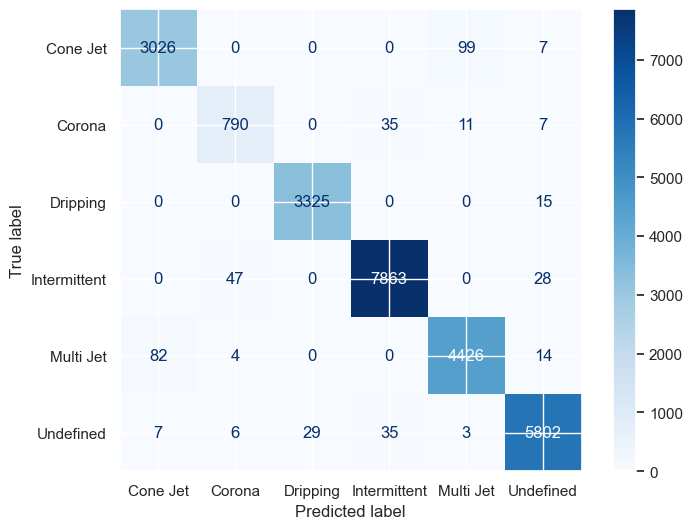

In [126]:
import matplotlib.pyplot as plt

predicted_labels = model.predict(X_test)
true_labels = y_test

label_names = ['Cone Jet', 'Corona', 'Dripping', 'Intermittent', 'Multi Jet', 'Undefined']
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [127]:
feature_names = X.columns
feature_importances = model.feature_importances_

feature_importances_dict = dict(zip(feature_names, feature_importances))
feature_importances_dict

{'mean': 0.17970787,
 'variance': 0.084429175,
 'deviation': 0.0,
 'median': 0.18725954,
 'rms': 0.02618963,
 'voltage': 0.05320514,
 'flow_rate': 0.020524397,
 'Undimensional_flowrate': 0.022308476,
 'Undimensional_voltage': 0.07324975,
 'mean/median': 0.19672339,
 'std_dev/median': 0.15640262}

Now, using the model obtained, we are going to predict the values of the spray_mode of a dataset without classification

In [128]:
df = pd.read_feather('../data/EWG262_testing.feather')
df = df.drop(['index'], axis='columns')
df.head()

,name,mean,variance,deviation,median,rms,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage
0,setup/liquid/EWG262,1.518008,12.278052,3.504005,1.513050,3.818691,3000.55,1,2.580079e-11,1.120261
1,setup/liquid/EWG262,0.958199,11.873786,3.445836,1.008700,3.576581,3000.55,1,2.580079e-11,1.120261
2,setup/liquid/EWG262,0.906196,12.078447,3.475406,1.008700,3.591607,3000.55,1,2.580079e-11,1.120261
3,setup/liquid/EWG262,1.445982,12.245024,3.499289,1.513050,3.786276,3000.55,1,2.580079e-11,1.120261
4,setup/liquid/EWG262,1.186080,11.947852,3.456567,1.260875,3.654400,3200.40,1,2.580079e-11,1.274459


In [129]:
#Treating median values
non_zero_dripping_df = df.loc[(df['median'] != 0)]
mean_of_median = non_zero_dripping_df.loc[:, 'median'].mean()
rows_to_replace = (df['median'] == 0)
df.loc[rows_to_replace, 'median'] = mean_of_median

In [130]:
df = df.drop(['name'], axis='columns')
df["mean/median"] = df["mean"]/df["median"]
df["std_dev/median"] = df["deviation"]/df["median"]
df.head()

,mean,variance,deviation,median,rms,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage,mean/median,std_dev/median
0,1.518008,12.278052,3.504005,1.513050,3.818691,3000.55,1,2.580079e-11,1.120261,1.003277,2.315855
1,0.958199,11.873786,3.445836,1.008700,3.576581,3000.55,1,2.580079e-11,1.120261,0.949935,3.416116
2,0.906196,12.078447,3.475406,1.008700,3.591607,3000.55,1,2.580079e-11,1.120261,0.898380,3.445431
3,1.445982,12.245024,3.499289,1.513050,3.786276,3000.55,1,2.580079e-11,1.120261,0.955673,2.312738
4,1.186080,11.947852,3.456567,1.260875,3.654400,3200.40,1,2.580079e-11,1.274459,0.940680,2.741403


In [131]:
len(df.loc[(df['mean/median'] == np.inf) | (df['std_dev/median'] == np.inf)])

0

In [132]:
# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.dropna(inplace=True)
# df.head()

In [133]:
predicted_labels = model.predict(df)
print(predicted_labels[0:100])

[5 5 2 5 5 5 2 5 5 5 5 2 5 5 5 5 5 5 5 2 5 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 2
 5 2 5 5 5 2 5 2 2 5 5 2 2 3 5 2 3 5 2 5 5 5 5 5 2 2 3 5 5 3 5 5 5 5 3 5 5
 5 5 5 5 5 3 3 5 5 3 5 5 5 5 3 3 5 5 5 5 3 5 5 5 5 5]


In [134]:
predicted_class_names = ["Cone Jet" if label == 0 else
                          "Corona" if label == 1 else
                          "Dripping" if label == 2 else
                          "Intermittent" if label == 3 else
                          "Multi Jet" if label == 4 else
                          "Undefined" for label in predicted_labels]

predicted_labels = predicted_class_names

In [135]:
print(predicted_labels[0:100])

['Undefined', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Dripping', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Dripping', 'Dripping', 'Undefined', 'Undefined', 'Dripping', 'Dripping', 'Intermittent', 'Undefined', 'Dripping', 'Intermittent', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Dripping', 'Intermittent', 'Undefined', 'Undefined', 'Intermittent', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Intermittent', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 

In [136]:
# Importing and treating the true values of the label to compare

df = pd.read_feather("../data/EWG262_relabeled.feather")
df = df.drop(['name'], axis='columns')
df["mean/median"] = df["mean"]/df["median"]
df["std_dev/median"] = df["deviation"]/df["median"]
# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.dropna(inplace=True)
true_values = df['spray_mode']
# len(true_values)
# print(true_values)

In [137]:
#Treating median values
non_zero_dripping_df = df.loc[(df['median'] != 0)]
mean_of_median = non_zero_dripping_df.loc[:, 'median'].mean()
rows_to_replace = (df['median'] == 0)
df.loc[rows_to_replace, 'median'] = mean_of_median

In [138]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, accuracy_score

accuracy = accuracy_score(predicted_labels, true_values)
accuracy

0.9623100303951367

Now we are going to plot the mode classification map based on the prediction we have made

In [139]:
df['spray_mode'] = predicted_labels
df = df.drop(['index'], axis='columns')
df.head()

,mean,variance,deviation,median,rms,spray_mode,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage,mean/median,std_dev/median
0,1.518008,12.278052,3.504005,1.513050,3.818691,Undefined,3000.55,1,2.580079e-11,1.120261,1.003277,2.315855
1,0.958199,11.873786,3.445836,1.008700,3.576581,Undefined,3000.55,1,2.580079e-11,1.120261,0.949935,3.416116
2,0.906196,12.078447,3.475406,1.008700,3.591607,Dripping,3000.55,1,2.580079e-11,1.120261,0.898380,3.445431
3,1.445982,12.245024,3.499289,1.513050,3.786276,Undefined,3000.55,1,2.580079e-11,1.120261,0.955673,2.312738
4,1.186080,11.947852,3.456567,1.260875,3.654400,Undefined,3200.40,1,2.580079e-11,1.274459,0.940680,2.741403


In [140]:
import seaborn as sns
sns.set(color_codes=True)
from matplotlib.lines import Line2D

def plot_mapping(df):
    colormap = []
    for electro_class in df['spray_mode']:
        if electro_class == 'Intermittent':
            colormap.append('red')
        elif electro_class == 'Cone Jet':
            colormap.append('orange')
        elif electro_class == 'Dripping':
            colormap.append('blue')
        elif electro_class == 'Multi Jet':
            colormap.append('purple')
        elif electro_class == 'Undefined':
            colormap.append('green')
        elif electro_class == 'Corona':
            colormap.append('pink')    
        else:
            colormap.append('orange')


    df.insert(1, 'colormap', colormap)
    df.info()

   #Scatterplot

    inverse_voltage = df['voltage']

    # Define a palette com as cores
    custom_palette = {'blue': 'steelblue', 'orange': 'orange', 'red': 'firebrick', 'green': 'green', 'purple': 'rebeccapurple', 'pink': 'hotpink'}

    # Plotagem
    fig, ax = plt.subplots(figsize=(20, 9))
    fig.patch.set_facecolor('white')  # Define a cor de fundo da figura como branco

    scatterplot = sns.scatterplot(data=df, x='Undimensional_flowrate', y='Undimensional_voltage', hue='colormap', palette=custom_palette, ax=ax, alpha=0.7, s=100)
    ax.set_xscale("log")
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_yticks([2, 4, 6, 8, 10])
    Xtick = df.Undimensional_flowrate[0] #Defining the xticks
    ax.set_xticks([Xtick,(Xtick*2),(Xtick*5),(Xtick*10),(Xtick*20),(Xtick*50),(Xtick*100),(Xtick*200),(Xtick*500)])
    ax.set_ylabel('γ1', fontsize=22, labelpad=1)
    ax.set_xlabel('Q / Q0', fontsize=22,labelpad=15)

    # Increase font size for ticks and tick labels on primary axes
    ax.tick_params(axis='both', which='major', labelsize=20)

    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Dripping', markerfacecolor='cadetblue', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Intermittent', markerfacecolor='firebrick', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Multi Jet', markerfacecolor='rebeccapurple', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Cone Jet', markerfacecolor='orange', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Undefined', markerfacecolor='green', markersize=10)]

    plt.title("Mapping Jet Modes -  EWG262", fontsize=20, pad=40)
    legend = ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), fontsize=22)  # Adjust font size here


    plt.show()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13160 entries, 0 to 13159
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean                    13160 non-null  float64
 1   colormap                13160 non-null  object 
 2   variance                13160 non-null  float64
 3   deviation               13160 non-null  float64
 4   median                  13160 non-null  float64
 5   rms                     13160 non-null  float64
 6   spray_mode              13160 non-null  object 
 7   voltage                 13160 non-null  float64
 8   flow_rate               13160 non-null  int64  
 9   Undimensional_flowrate  13160 non-null  float64
 10  Undimensional_voltage   13160 non-null  float64
 11  mean/median             13160 non-null  float64
 12  std_dev/median          13160 non-null  float64
dtypes: float64(10), int64(1), object(2)
memory usage: 1.3+ MB


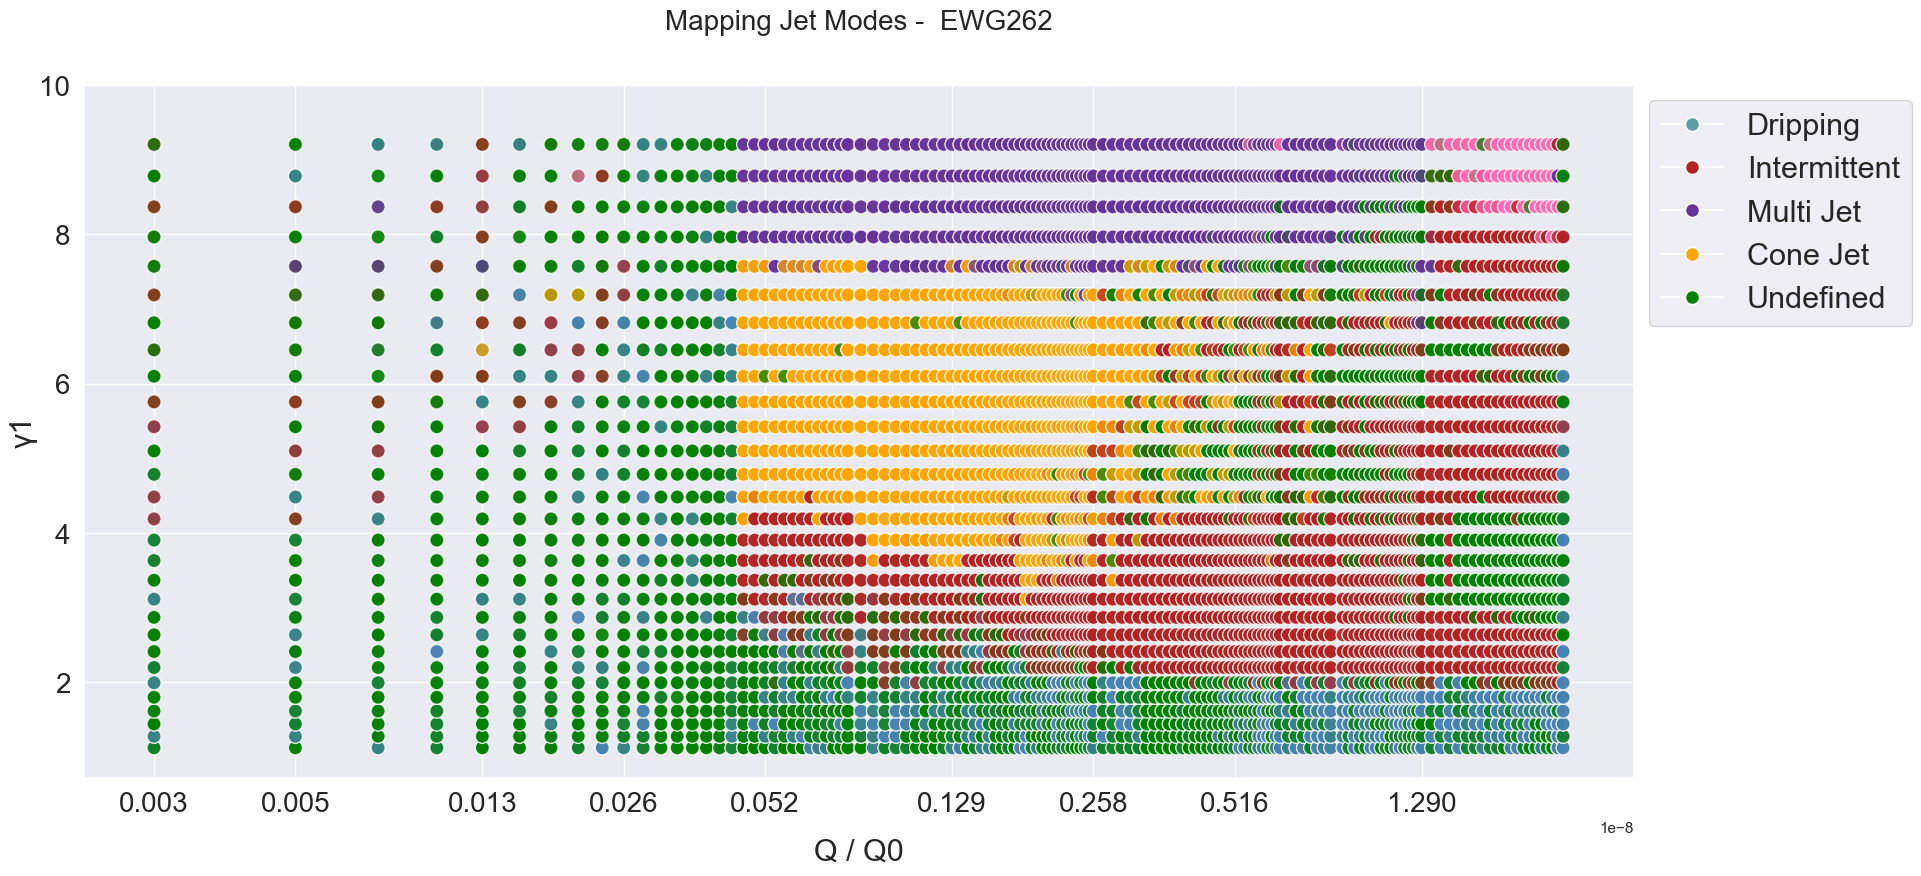

In [141]:
plot_mapping(df)

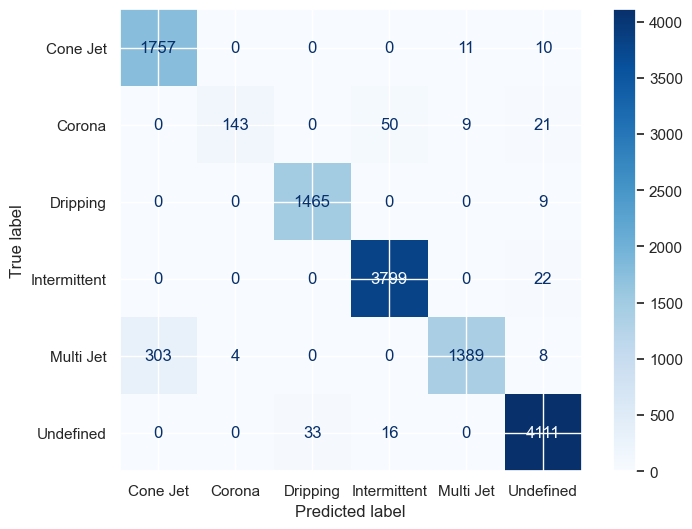

In [142]:
label_names = ['Cone Jet', 'Corona', 'Dripping', 'Intermittent', 'Multi Jet', 'Undefined']
cm = confusion_matrix(true_values, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

Since the XGBoost has a lot of hyperparameters that can be adjusted (like eta, gamma, and max depth), we will do a cross validation to try to get the optimal values of those.

In [143]:
from sklearn.model_selection import GridSearchCV

In [144]:
# param_grid = {
#     'max_depth': [1,3],
#     'gamma': [0],
#     'learning_rate': [0.3],
#     'reg_lambda': [10, 20, 100], #Search more into this parameter
#     'scale_pos_weight': [1, 3, 5] #Search more into this parameter
# }
# optimal_params = GridSearchCV(
#     estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_bytree=0.5),
#     param_grid=param_grid,
#     scoring='roc_auc',
#     verbose=2,
#     n_jobs=-1
# )

# optimal_params.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

# print(optimal_params.best_params_)

In [145]:
optimized_params_tree = xgb.XGBClassifier(gamma=0, learning_rate=0.3, max_depth=1, reg_lambda=10, scale_pos_weight=1)

In [146]:
optimized_params_tree.fit(X_train, y_train, verbose=True)

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:19:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [147]:
optimized_params_tree.score(X_test, y_test)

0.9192938700752115

In [148]:
df = pd.read_feather('../data/EWG262_testing.feather')
df = df.drop(['index'], axis='columns')
df.head()

,name,mean,variance,deviation,median,rms,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage
0,setup/liquid/EWG262,1.518008,12.278052,3.504005,1.513050,3.818691,3000.55,1,2.580079e-11,1.120261
1,setup/liquid/EWG262,0.958199,11.873786,3.445836,1.008700,3.576581,3000.55,1,2.580079e-11,1.120261
2,setup/liquid/EWG262,0.906196,12.078447,3.475406,1.008700,3.591607,3000.55,1,2.580079e-11,1.120261
3,setup/liquid/EWG262,1.445982,12.245024,3.499289,1.513050,3.786276,3000.55,1,2.580079e-11,1.120261
4,setup/liquid/EWG262,1.186080,11.947852,3.456567,1.260875,3.654400,3200.40,1,2.580079e-11,1.274459


In [149]:
#Treating median values
non_zero_dripping_df = df.loc[(df['median'] != 0)]
mean_of_median = non_zero_dripping_df.loc[:, 'median'].mean()
rows_to_replace = (df['median'] == 0)
df.loc[rows_to_replace, 'median'] = mean_of_median

In [150]:
df = df.drop(['name'], axis='columns')
df["mean/median"] = df["mean"]/df["median"]
df["std_dev/median"] = df["deviation"]/df["median"]
df.head()

,mean,variance,deviation,median,rms,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage,mean/median,std_dev/median
0,1.518008,12.278052,3.504005,1.513050,3.818691,3000.55,1,2.580079e-11,1.120261,1.003277,2.315855
1,0.958199,11.873786,3.445836,1.008700,3.576581,3000.55,1,2.580079e-11,1.120261,0.949935,3.416116
2,0.906196,12.078447,3.475406,1.008700,3.591607,3000.55,1,2.580079e-11,1.120261,0.898380,3.445431
3,1.445982,12.245024,3.499289,1.513050,3.786276,3000.55,1,2.580079e-11,1.120261,0.955673,2.312738
4,1.186080,11.947852,3.456567,1.260875,3.654400,3200.40,1,2.580079e-11,1.274459,0.940680,2.741403


In [151]:
predicted_labels = optimized_params_tree.predict(df)
print(predicted_labels[0:5])

proba_predicted_labels = optimized_params_tree.predict_proba(df)
print(proba_predicted_labels[0:5])

max_probs = np.max(proba_predicted_labels, axis=1)
print(max_probs[0:5])

[5 5 5 5 5]
[[3.32876039e-03 1.15082665e-04 6.50222693e-03 2.52884696e-04
  4.54993453e-04 9.89346087e-01]
 [2.82797264e-03 1.13039961e-04 2.45784428e-02 2.48396012e-04
  4.46917373e-04 9.71785307e-01]
 [2.54532060e-04 7.36457441e-05 3.63911331e-01 2.55418522e-03
  8.63263776e-05 6.33119941e-01]
 [2.87171081e-03 1.14788265e-04 9.49227996e-03 2.52237776e-04
  4.53829503e-04 9.86815214e-01]
 [2.17622542e-03 1.14868330e-04 9.49890073e-03 2.52413709e-04
  4.54146037e-04 9.87503469e-01]]
[0.9893461  0.9717853  0.63311994 0.9868152  0.98750347]


In [152]:
predicted_class_names = ["Cone Jet" if label == 0 else
                          "Corona" if label == 1 else
                          "Dripping" if label == 2 else
                          "Intermittent" if label == 3 else
                          "Multi Jet" if label == 4 else
                          "Undefined" for label in predicted_labels]

predicted_labels = predicted_class_names
print(predicted_labels[0:100])

['Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Dripping', 'Dripping', 'Dripping', 'Undefined', 'Dripping', 'Dripping', 'Intermittent', 'Undefined', 'Dripping', 'Intermittent', 'Undefined', 'Dripping', 'Undefined', 'Undefined', 'Undefined', 'Dripping', 'Undefined', 'Dripping', 'Dripping', 'Intermittent', 'Undefined', 'Dripping', 'Intermittent', 'Cone Jet', 'Cone Jet', 'Cone Jet', 'Cone Jet', 'Intermittent', 'Dripping', 'Undefined', 'Cone Jet', 'Cone Jet', 'Cone Jet', 'Cone Jet

In [153]:
# Importing and treating the true values of the label to compare

df = pd.read_feather("../data/EWG262_relabeled.feather")
df = df.drop(['name'], axis='columns')
df["mean/median"] = df["mean"]/df["median"]
df["std_dev/median"] = df["deviation"]/df["median"]
# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.dropna(inplace=True)
true_values = df['spray_mode']
len(true_values)
print(true_values)

0        Undefined
1        Undefined
2         Dripping
3        Undefined
4        Undefined
           ...    
13155    Undefined
13156    Undefined
13157       Corona
13158    Undefined
13159    Undefined
Name: spray_mode, Length: 13160, dtype: object


In [154]:
#Treating median values
non_zero_dripping_df = df.loc[(df['median'] != 0)]
mean_of_median = non_zero_dripping_df.loc[:, 'median'].mean()
rows_to_replace = (df['median'] == 0)
df.loc[rows_to_replace, 'median'] = mean_of_median

In [155]:
accuracy = accuracy_score(predicted_labels, true_values)
accuracy

0.908662613981763

In [156]:
from sklearn.metrics import f1_score
f1 = f1_score(predicted_labels, true_values, average='weighted')
print(f1)

0.9141570913185075


In [157]:
df['spray_mode'] = predicted_labels
df['predict_proba'] = max_probs
df = df.drop(['index'], axis='columns')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13160 entries, 0 to 13159
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean                    13160 non-null  float64
 1   colormap                13160 non-null  object 
 2   variance                13160 non-null  float64
 3   deviation               13160 non-null  float64
 4   median                  13160 non-null  float64
 5   rms                     13160 non-null  float64
 6   spray_mode              13160 non-null  object 
 7   voltage                 13160 non-null  float64
 8   flow_rate               13160 non-null  int64  
 9   Undimensional_flowrate  13160 non-null  float64
 10  Undimensional_voltage   13160 non-null  float64
 11  mean/median             13160 non-null  float64
 12  std_dev/median          13160 non-null  float64
 13  predict_proba           13160 non-null  float32
dtypes: float32(1), float64(10), int64(1), 

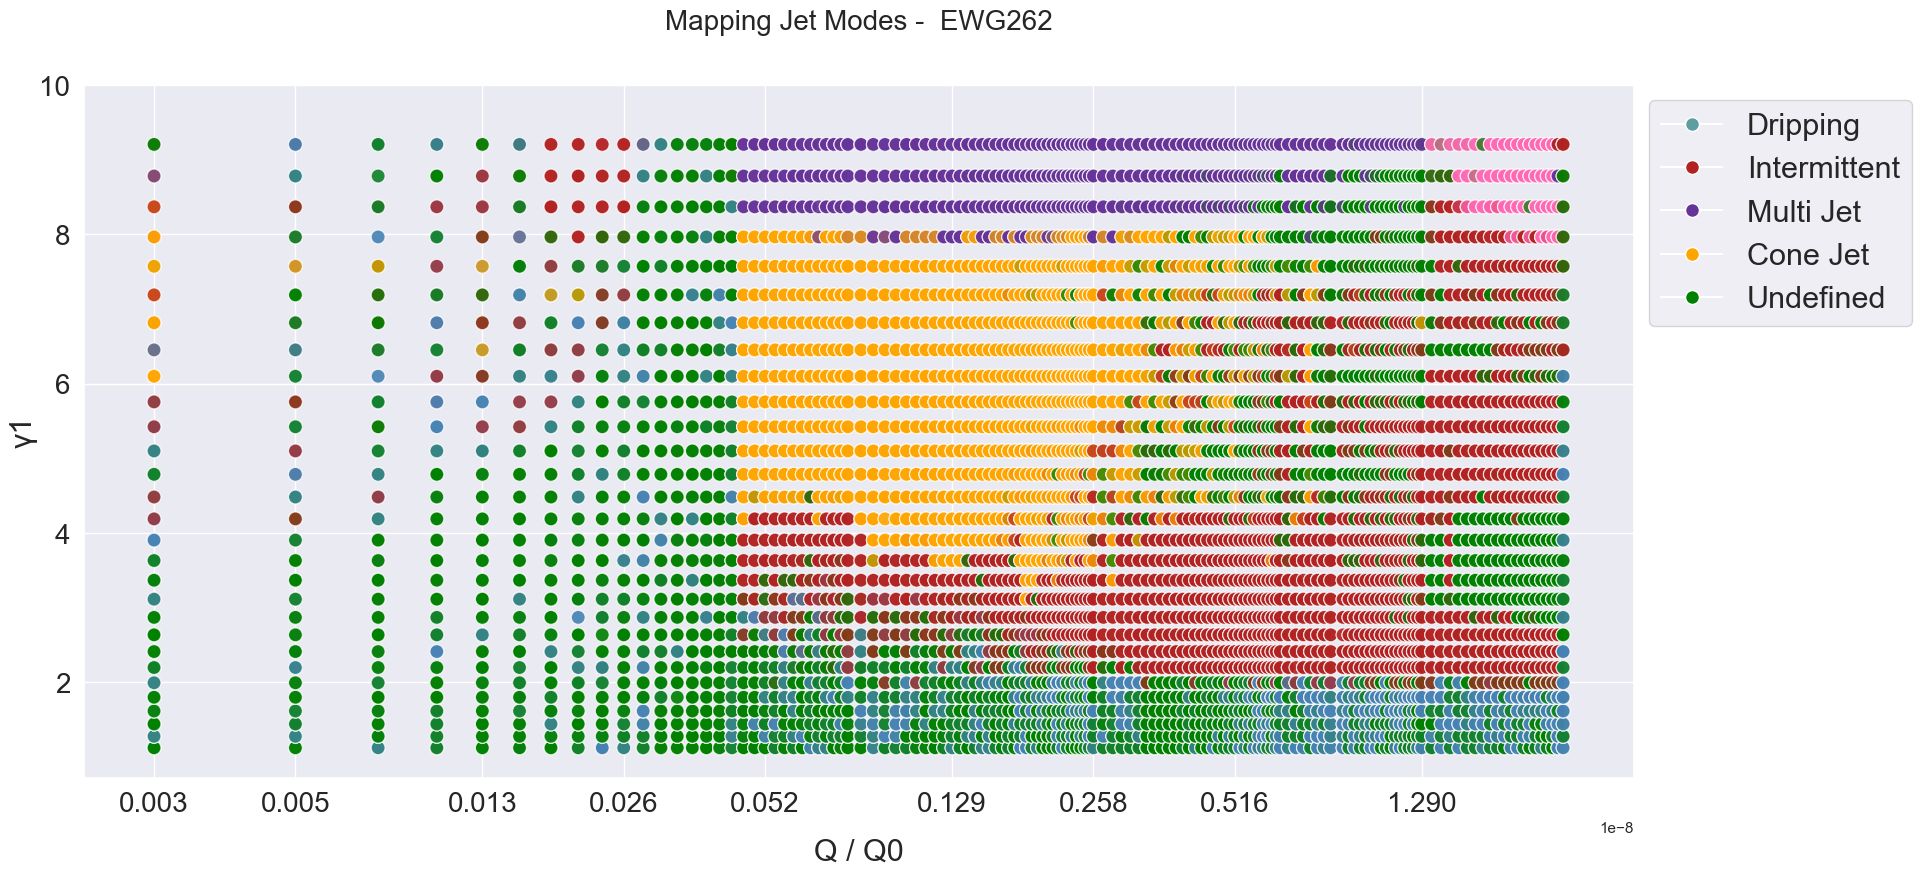

In [158]:
plot_mapping(df)

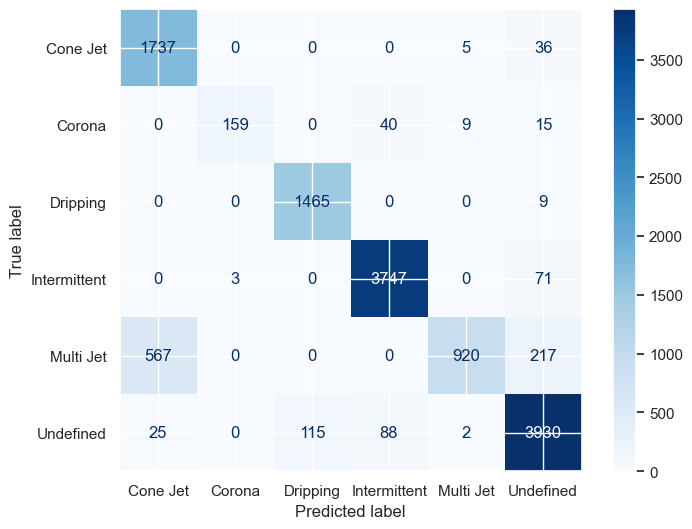

In [159]:
label_names = ['Cone Jet', 'Corona', 'Dripping', 'Intermittent', 'Multi Jet', 'Undefined']
cm = confusion_matrix(true_values, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [160]:
import itertools

def plot_normalized_confusion_matrix(y_true, y_pred, classes, title='Normalized Confusion Matrix', cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()  

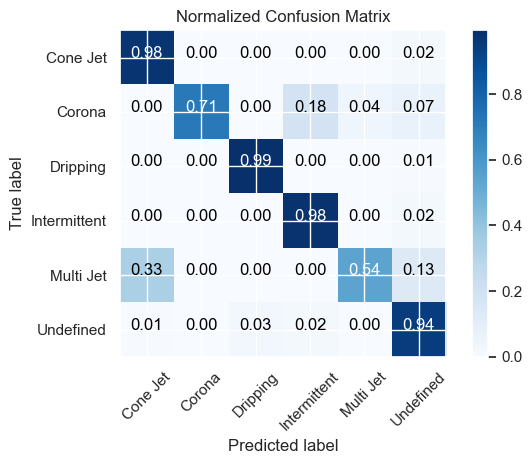

In [161]:
plot_normalized_confusion_matrix(true_values, predicted_labels, label_names)
plt.show()

Finding the predictions that had a trustability of >0.95

In [162]:
threshold = 0.85

filtered_df = df.loc[(df["spray_mode"] == "Cone Jet") & (df['predict_proba'] >= threshold)]

filtered_df[['flow_rate', 'voltage', 'spray_mode', 'predict_proba']]

,flow_rate,voltage,spray_mode,predict_proba
68,1,7000.45,Cone Jet,0.871026
70,1,7200.27,Cone Jet,0.882891
75,1,7400.43,Cone Jet,0.882891
76,1,7400.43,Cone Jet,0.876961
77,1,7600.24,Cone Jet,0.851216
...,...,...,...,...
7452,170,7000.43,Cone Jet,0.879111
7455,170,7200.25,Cone Jet,0.861965
7531,175,6000.39,Cone Jet,0.917543
8006,200,6000.38,Cone Jet,0.913195


In [163]:
df.loc[(df["spray_mode"] == "Cone Jet") & (df['predict_proba'] >= threshold), 'colormap'] = 'black'

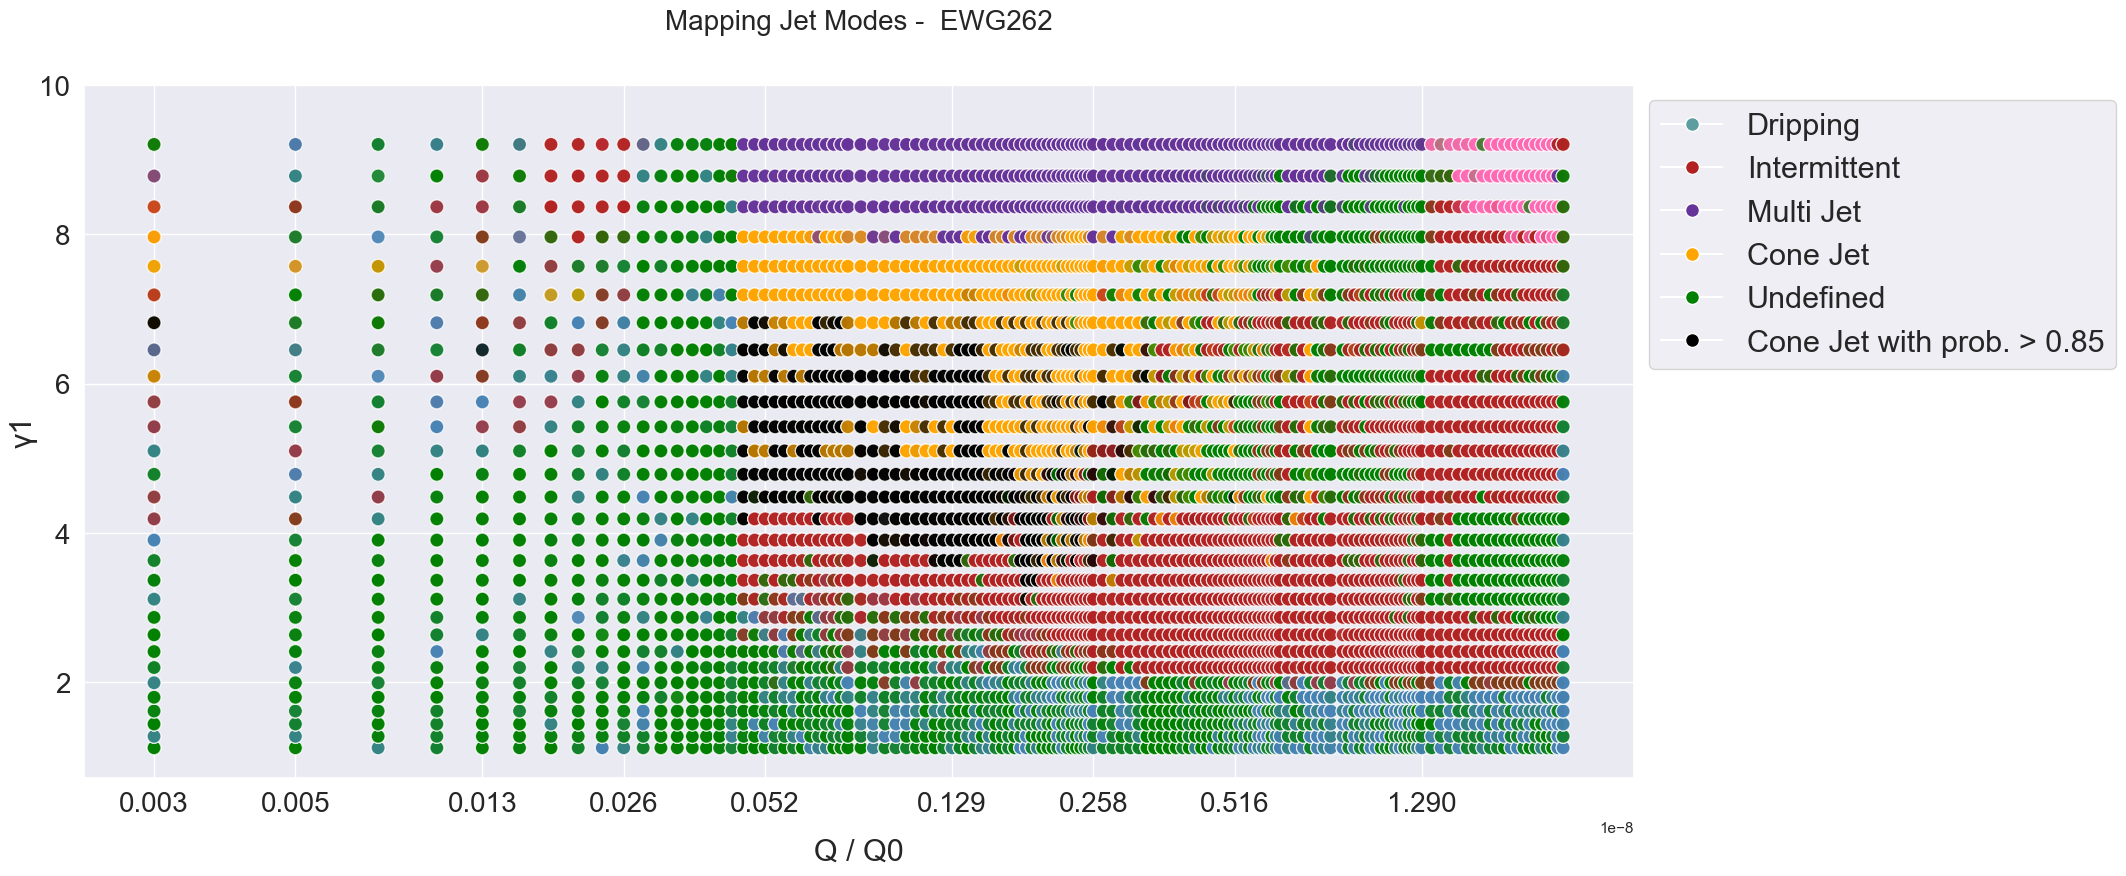

In [164]:
 #Scatterplot
inverse_voltage = df['voltage']

    # Define a palette com as cores
custom_palette = {'blue': 'steelblue', 'orange': 'orange', 'red': 'firebrick', 'green': 'green', 'purple': 'rebeccapurple', 'pink': 'hotpink', 'black': 'black'}

    # Plotagem
fig, ax = plt.subplots(figsize=(20, 9))
fig.patch.set_facecolor('white')  # Define a cor de fundo da figura como branco

scatterplot = sns.scatterplot(data=df, x='Undimensional_flowrate', y='Undimensional_voltage', hue='colormap', palette=custom_palette, ax=ax, alpha=0.7, s=100)
ax.set_xscale("log")
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_yticks([2, 4, 6, 8, 10])
Xtick = df.Undimensional_flowrate[0] #Defining the xticks
ax.set_xticks([Xtick,(Xtick*2),(Xtick*5),(Xtick*10),(Xtick*20),(Xtick*50),(Xtick*100),(Xtick*200),(Xtick*500)])
ax.set_ylabel('γ1', fontsize=22, labelpad=1)
ax.set_xlabel('Q / Q0', fontsize=22,labelpad=15)

# Increase font size for ticks and tick labels on primary axes
ax.tick_params(axis='both', which='major', labelsize=20)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Dripping', markerfacecolor='cadetblue', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Intermittent', markerfacecolor='firebrick', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Multi Jet', markerfacecolor='rebeccapurple', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Cone Jet', markerfacecolor='orange', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Undefined', markerfacecolor='green', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Cone Jet with prob. > 0.85', markerfacecolor='black', markersize=10),
                ]

plt.title("Mapping Jet Modes -  EWG262", fontsize=20, pad=40)
legend = ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), fontsize=22)  # Adjust font size here


plt.show()

Saving the model

In [165]:
from joblib import dump, load

dump(optimized_params_tree, 'xgb8liquid-testmodel.joblib')

['xgb8liquid-testmodel.joblib']

In [166]:
from sklearn.metrics import log_loss

pred_proba = proba_predicted_labels
true_values = np.array(true_values)

print(true_values)
print(pred_proba)

log_loss_value = log_loss(true_values, pred_proba)

print(f'Log Loss: {log_loss_value}')


['Undefined' 'Undefined' 'Dripping' ... 'Corona' 'Undefined' 'Undefined']
[[3.32876039e-03 1.15082665e-04 6.50222693e-03 2.52884696e-04
  4.54993453e-04 9.89346087e-01]
 [2.82797264e-03 1.13039961e-04 2.45784428e-02 2.48396012e-04
  4.46917373e-04 9.71785307e-01]
 [2.54532060e-04 7.36457441e-05 3.63911331e-01 2.55418522e-03
  8.63263776e-05 6.33119941e-01]
 ...
 [8.32891819e-05 5.47218435e-02 1.42817721e-02 7.54687369e-01
  8.55642546e-04 1.75370142e-01]
 [2.44153071e-05 1.73642649e-03 3.09908460e-03 9.63945806e-01
  2.30979567e-04 3.09632998e-02]
 [1.30209010e-04 1.08235395e-02 2.60956772e-02 7.68509507e-01
  1.43974787e-03 1.93001285e-01]]
Log Loss: 0.2601091445557979
